## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
/Users/chibaryowei/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chibaryowei/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chibaryowei/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chibaryowei/anaconda3/lib/pytho

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [19]:

from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_2(input_shape, output_units=10, num_neurons=[256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [20]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 0.01
EPOCHS = 20
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.5

In [15]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for batch in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with batch size = %.6f" % (batch))
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size= batch, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
 
    exp_name_tag = "exp-batch size-%s" % str(batch)
    
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    

Experiment with batch size = 2.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12

50000/50000 [==============================] - 499s 10ms/step - loss: 2.2632 - acc: 0.1447 - val_loss: 2.5638 - val_acc: 0.1561
Epoch 50/50
50000/50000 [==============================] - 495s 10ms/step - loss: 2.2610 - acc: 0.1469 - val_loss: 2.5846 - val_acc: 0.1598
Experiment with batch size = 16.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (Non

50000/50000 [==============================] - 80s 2ms/step - loss: 1.1085 - acc: 0.6075 - val_loss: 1.3273 - val_acc: 0.5376
Epoch 48/50
50000/50000 [==============================] - 79s 2ms/step - loss: 1.1040 - acc: 0.6072 - val_loss: 1.3668 - val_acc: 0.5278
Epoch 49/50
50000/50000 [==============================] - 79s 2ms/step - loss: 1.1004 - acc: 0.6082 - val_loss: 1.3309 - val_acc: 0.5359
Epoch 50/50
50000/50000 [==============================] - 70s 1ms/step - loss: 1.0940 - acc: 0.6119 - val_loss: 1.3236 - val_acc: 0.5371
Experiment with batch size = 32.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Ba

50000/50000 [==============================] - 35s 709us/step - loss: 0.8131 - acc: 0.7084 - val_loss: 1.5556 - val_acc: 0.5088
Epoch 46/50
50000/50000 [==============================] - 35s 706us/step - loss: 0.8117 - acc: 0.7096 - val_loss: 1.6058 - val_acc: 0.4950
Epoch 47/50
50000/50000 [==============================] - 35s 702us/step - loss: 0.8054 - acc: 0.7123 - val_loss: 1.5883 - val_acc: 0.4990
Epoch 48/50
50000/50000 [==============================] - 36s 722us/step - loss: 0.8015 - acc: 0.7138 - val_loss: 1.5796 - val_acc: 0.4993
Epoch 49/50
50000/50000 [==============================] - 36s 719us/step - loss: 0.7968 - acc: 0.7137 - val_loss: 1.6493 - val_acc: 0.4921
Epoch 50/50
50000/50000 [==============================] - 151s 3ms/step - loss: 0.7894 - acc: 0.7171 - val_loss: 1.8195 - val_acc: 0.4605
Experiment with batch size = 128.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
i

50000/50000 [==============================] - 20s 405us/step - loss: 0.3213 - acc: 0.8897 - val_loss: 2.3314 - val_acc: 0.4655
Epoch 44/50
50000/50000 [==============================] - 21s 426us/step - loss: 0.3101 - acc: 0.8947 - val_loss: 2.4272 - val_acc: 0.4455
Epoch 45/50
50000/50000 [==============================] - 19s 377us/step - loss: 0.3027 - acc: 0.8956 - val_loss: 2.4461 - val_acc: 0.4487
Epoch 46/50
50000/50000 [==============================] - 20s 391us/step - loss: 0.2978 - acc: 0.8983 - val_loss: 2.3837 - val_acc: 0.4628
Epoch 47/50
50000/50000 [==============================] - 17s 344us/step - loss: 0.2837 - acc: 0.9034 - val_loss: 2.6200 - val_acc: 0.4495
Epoch 48/50
50000/50000 [==============================] - 17s 341us/step - loss: 0.2774 - acc: 0.9051 - val_loss: 2.4431 - val_acc: 0.4501
Epoch 49/50
50000/50000 [==============================] - 16s 320us/step - loss: 0.2678 - acc: 0.9081 - val_loss: 2.4597 - val_acc: 0.4582
Epoch 50/50
50000/50000 [=======

50000/50000 [==============================] - 13s 267us/step - loss: 0.2682 - acc: 0.9210 - val_loss: 2.2097 - val_acc: 0.4748
Epoch 42/50
50000/50000 [==============================] - 14s 288us/step - loss: 0.2518 - acc: 0.9273 - val_loss: 2.3531 - val_acc: 0.4706
Epoch 43/50
50000/50000 [==============================] - 11s 220us/step - loss: 0.2446 - acc: 0.9286 - val_loss: 2.2439 - val_acc: 0.4700
Epoch 44/50
50000/50000 [==============================] - 12s 234us/step - loss: 0.2240 - acc: 0.9379 - val_loss: 2.2366 - val_acc: 0.4785
Epoch 45/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.2148 - acc: 0.9403 - val_loss: 2.3236 - val_acc: 0.4583
Epoch 46/50
50000/50000 [==============================] - 12s 234us/step - loss: 0.2092 - acc: 0.9418 - val_loss: 2.3051 - val_acc: 0.4707
Epoch 47/50
50000/50000 [==============================] - 12s 232us/step - loss: 0.1964 - acc: 0.9460 - val_loss: 2.5475 - val_acc: 0.4643
Epoch 48/50
50000/50000 [=======

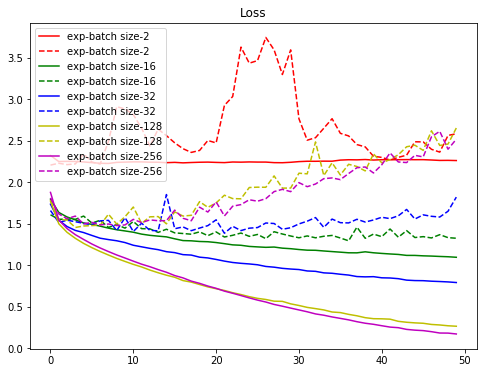

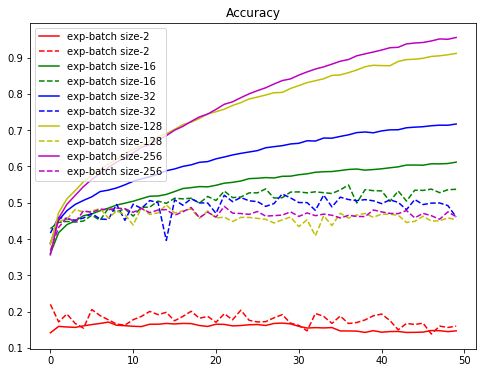

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### MODEL 2

In [21]:
results_2 = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for batch in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with batch size = %.6f" % (batch))
    
    model = build_mlp_2(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size= batch, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-batch size-%s" % str(batch)
    
    results_2[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    

Experiment with batch size = 2.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 834,186
Trainable params: 827,530
Non-trainable params: 6,656
____________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 30s 594us/step - loss: 1.6679 - acc: 0.4122 - val_loss: 1.4844 - val_acc: 0.4720
Epoch 2/20
50000/50000 [==============================] - 30s 601us/step - loss: 1.4504 - acc: 0.4864 - val_loss: 1.4168 - val_acc: 0.4960
Epoch 3/20
50000/50000 [==============================] - 29s 584us/step - loss: 1.3576 - acc: 0.5161 - val_loss: 1.3808 - val_acc: 0.5102
Epoch 4/20
50000/50000 [==============================] - 29s 580us/step - loss: 1.2920 - acc: 0.5433 - val_loss: 1.3438 - val_acc: 0.5223
Epoch 5/20
50000/50000 [==============================] - 32s 646us/step - loss: 1.2391 - acc: 0.5633 - val_loss: 1.3525 - val_acc: 0.5195
Epoch 6/20
50000/50000 [==============================] - 37s 741us/step - loss: 1.1989 - acc: 0.5761 - val_loss: 1.3288 - val_acc: 0.5286
Epoch 7/20
50000/50000 [==============================] - 32s 640us/step - loss: 1.1500 - acc: 0.5896 - val_loss: 1.

Epoch 2/20
50000/50000 [==============================] - 13s 250us/step - loss: 1.5463 - acc: 0.4557 - val_loss: 1.5245 - val_acc: 0.4665
Epoch 3/20
50000/50000 [==============================] - 13s 262us/step - loss: 1.4483 - acc: 0.4919 - val_loss: 1.4782 - val_acc: 0.4754
Epoch 4/20
50000/50000 [==============================] - 13s 262us/step - loss: 1.3793 - acc: 0.5166 - val_loss: 1.4520 - val_acc: 0.4868
Epoch 5/20
50000/50000 [==============================] - 14s 270us/step - loss: 1.3212 - acc: 0.5366 - val_loss: 1.4223 - val_acc: 0.4979
Epoch 6/20
50000/50000 [==============================] - 13s 270us/step - loss: 1.2749 - acc: 0.5557 - val_loss: 1.4021 - val_acc: 0.5043
Epoch 7/20
50000/50000 [==============================] - 13s 268us/step - loss: 1.2318 - acc: 0.5732 - val_loss: 1.4077 - val_acc: 0.4977
Epoch 8/20
50000/50000 [==============================] - 13s 263us/step - loss: 1.1932 - acc: 0.5844 - val_loss: 1.3895 - val_acc: 0.5100
Epoch 9/20
50000/50000 [===

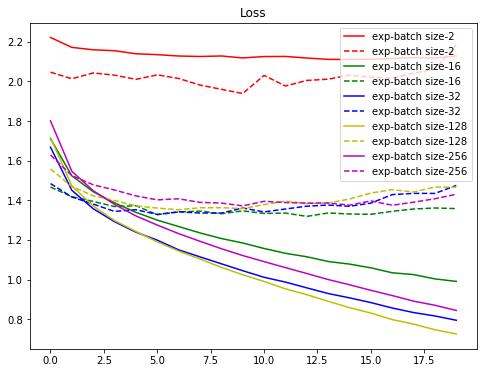

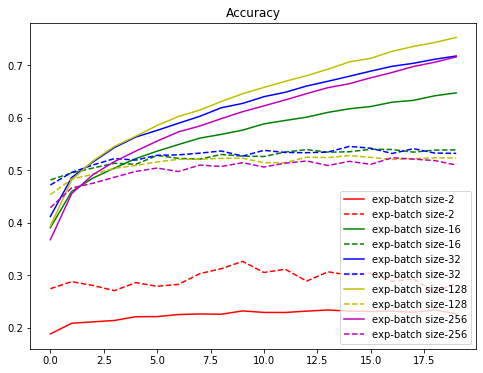

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_2.keys()):
    plt.plot(range(len(results_2[cond]['train-loss'])),results_2[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_2[cond]['valid-loss'])),results_2[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results_2.keys()):
    plt.plot(range(len(results_2[cond]['train-acc'])),results_2[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results_2[cond]['valid-acc'])),results_2[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()